In [1]:
import math
import random

import gym
import gym_warehouse
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical

In [2]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
use_cuda = torch.cuda.is_available()
device   = torch.device("cuda" if use_cuda else "cpu")

In [4]:
from collections import deque

class ReplayBuffer(object):
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)
    
    def push(self, state, action, reward, next_state, done, goal):
        self.buffer.append((state, action, reward, next_state, done, goal))
    
    def sample(self, batch_size):
        state, action, reward, next_state, done, goal = zip(*random.sample(self.buffer, batch_size))
        return np.stack(state), action, reward, np.stack(next_state), done, np.stack(goal)
    
    def __len__(self):
        return len(self.buffer)

In [5]:
class Env(object):
    def __init__(self, num_bits):
        self.num_bits = num_bits
    
    def reset(self):
        self.done      = False
        self.num_steps = 0
        self.state     = np.random.randint(2, size=self.num_bits)
        self.target    = np.random.randint(2, size=self.num_bits)
        return self.state, self.target
    
    def step(self, action):
        if self.done:
            raise RESET
        
        self.state[action] = 1 - self.state[action]
        
        if self.num_steps > self.num_bits + 1:
            self.done = True
        self.num_steps += 1
        
        if np.sum(self.state == self.target) == self.num_bits:
            self.done = True
            return np.copy(self.state), 0, self.done, {}
        else:
            return np.copy(self.state), -1, self.done, {}

In [6]:
class Model(nn.Module):
    def __init__(self, num_inputs, num_outputs, hidden_size=256):
        super(Model, self).__init__()
        
        self.linear1 = nn.Linear(num_inputs,  hidden_size)
        self.linear2 = nn.Linear(hidden_size, num_outputs)
    
    def forward(self, state, goal):
        x = torch.cat([state, goal], 1)
        x = F.relu(self.linear1(x))
        x = self.linear2(x)
        return x
    
def update_target(current_model, target_model):
    target_model.load_state_dict(current_model.state_dict())

In [7]:
def get_action(model, state, goal, epsilon=0.1):
    if random.random() < 0.1:
        return random.randrange(env.action_space.n)
    
    state = torch.FloatTensor(state).unsqueeze(0).to(device)
    goal  = torch.FloatTensor(goal).unsqueeze(0).to(device)
    q_value = model(state, goal)
#     print(q_value)
    return q_value.max(1)[1].item()

In [8]:
def plot(frame_idx, rewards, losses):
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('Mean Reward: %s. frame: %s' % (rewards[-1], frame_idx))
    plt.plot(rewards)
    plt.subplot(132)
    plt.title('loss')
    plt.plot(losses)
    plt.show()

In [9]:
def compute_td_error(batch_size):
    if batch_size > len(replay_buffer):
        return None

    state, action, reward, next_state, done, goal = replay_buffer.sample(batch_size)

    state      = torch.FloatTensor(state).to(device)
    reward     = torch.FloatTensor(reward).unsqueeze(1).to(device)
    action     = torch.LongTensor(action).unsqueeze(1).to(device)
    next_state = torch.FloatTensor(next_state).to(device)
    goal       = torch.FloatTensor(goal).to(device)
    mask       = torch.FloatTensor(1 - np.float32(done)).unsqueeze(1).to(device)
    
    q_values = model(state, goal)
    q_value  = q_values.gather(1, action)

    next_q_values = target_model(next_state, goal)
    target_action = next_q_values.max(1)[1].unsqueeze(1)
    next_q_value  = target_model(next_state, goal).gather(1, target_action)

    expected_q_value = reward + 0.99 * next_q_value * mask

    loss = (q_value - expected_q_value.detach()).pow(2).mean()

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    return loss

In [10]:
# num_bits = 11
env = gym.make("warehouse-v2")

model        = Model(2 * env.observation_space.shape[0]*env.observation_space.shape[1], env.action_space.n).to(device)
target_model = Model(2 * env.observation_space.shape[0]*env.observation_space.shape[1], env.action_space.n).to(device)
update_target(model, target_model)

#hyperparams:
batch_size = 32
new_goals  = 5
max_frames = 200000
    
optimizer = optim.Adam(model.parameters())
replay_buffer = ReplayBuffer(10000)

pygame 1.9.4
Hello from the pygame community. https://www.pygame.org/contribute.html


In [11]:
2*env.observation_space.shape[0]*env.observation_space.shape[1]

100

In [12]:
state,goal = env.reset()
state = state.flatten()
goal = goal.flatten()

In [13]:
#     state = torch.FloatTensor(state).unsqueeze(0).to(device)
#     goal  = torch.FloatTensor(goal).unsqueeze(0).to(device)

In [14]:
# torch.cat([state,goal],1).flatten().shape

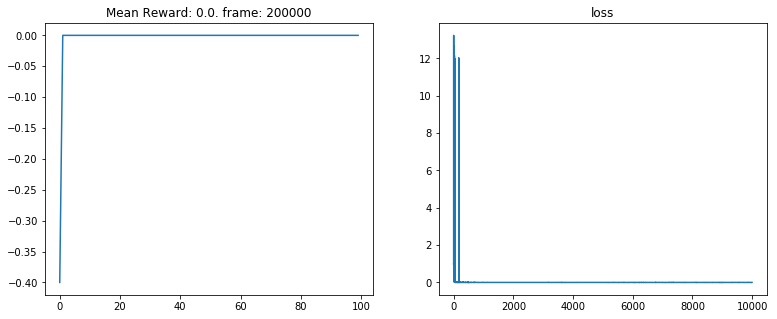

In [15]:
frame_idx = 0
all_rewards = []
losses = []

while frame_idx < max_frames:
    state,goal = env.reset()
    state = state.flatten()
    goal = goal.flatten()
    done = False
    episode = []
    total_reward = 0
    while not done:
        action = get_action(model, state, goal)
        next_state, reward, done, _ = env.step(action)
        next_state = next_state.flatten()
        replay_buffer.push(state, action, reward, next_state, done, goal)
        state = next_state
        total_reward += reward
        frame_idx += 1
        
        if frame_idx % 1000 == 0:
            plot(frame_idx, [np.mean(all_rewards[i:i+100]) for i in range(0, len(all_rewards), 100)], losses)
        
    all_rewards.append(total_reward)
    
    loss = compute_td_error(batch_size)
    if loss is not None: losses.append(loss.item())

## With HER

In [17]:
env = gym.make("warehouse-v2")

model        = Model(2 * env.observation_space.shape[0]*env.observation_space.shape[1], env.action_space.n).to(device)
target_model = Model(2 * env.observation_space.shape[0]*env.observation_space.shape[1], env.action_space.n).to(device)
update_target(model, target_model)

#hyperparams:
batch_size = 32
new_goals  = 5
max_frames = 200000
    
optimizer = optim.Adam(model.parameters())
replay_buffer = ReplayBuffer(10000)

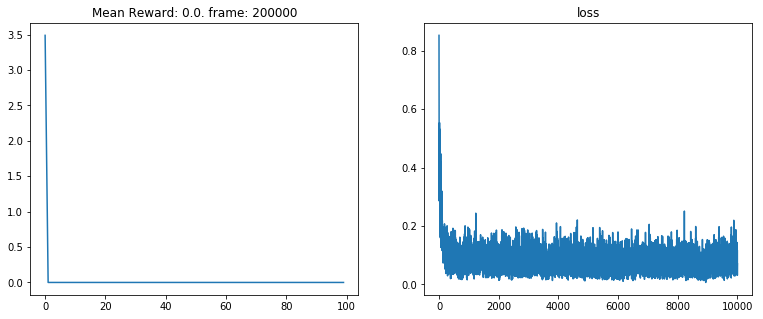

In [21]:
frame_idx = 0
all_rewards = []
losses = []

while frame_idx < max_frames:
    state, goal = env.reset()
    state = state.flatten()
    goal = goal.flatten()
    done = False
    episode = []
    total_reward = 0
    while not done:
        action = get_action(model, state, goal)
        next_state, reward, done, _ = env.step(action)
        next_state = next_state.flatten()
        episode.append((state, reward, done, next_state, goal))
        replay_buffer.push(state, action, reward, next_state, done, goal)
        state = next_state
        total_reward += reward
        frame_idx += 1
        
        if frame_idx % 10000 == 0:
            plot(frame_idx, [np.mean(all_rewards[i:i+100]) for i in range(0, len(all_rewards), 100)], losses)
        
    all_rewards.append(total_reward)
    
    
    new_episode = []
    for state, reward, done, next_state, goal in episode:
        for t in np.random.choice(env.action_space.n, new_goals):
            try:
                episode[t]
            except:
                continue
            new_goal = episode[t][-2]
            if np.sum(next_state == new_goal) == env.observation_space.shape[0]*env.observation_space.shape[1]:
                reward = 0
            else:
                reward = -1
            replay_buffer.push(state, action, reward, next_state, done, new_goal)
            new_episode.append((state, reward, done, next_state, new_goal))
    
    
    
    loss = compute_td_error(batch_size)
    if loss is not None: losses.append(loss.item())

## Visualize

In [23]:
env = gym.make("warehouse-v2")
frame_idx = 0
all_rewards = []
losses = []

while frame_idx < 100:
    state, goal = env.reset()
    env.render()
    state = state.flatten()
    goal = goal.flatten()
    done = False
    episode = []
    total_reward = 0
    while not done:
        action = get_action(model, state, goal)
        next_state, reward, done, _ = env.step(action)
        all_rewards.append(reward
        env.render()
        next_state = next_state.flatten()
        episode.append((state, reward, done, next_state, goal))
        replay_buffer.push(state, action, reward, next_state, done, goal)
        state = next_state
        total_reward += reward
        frame_idx += 1
        if frame_idx % 10000 == 0:
            plot(frame_idx, [np.mean(all_rewards[i:i+100]) for i in range(0, len(all_rewards), 100)], losses)
        
        

KeyboardInterrupt: 